# Multi-class Logistic Regression

## Loading the data

scipy : 과학 컴퓨팅과 기술 컴퓨팅에 사용되는 오픈 소스 파이썬 라이브러리  
scipy.io.loadmat() : MATLAB 파일 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

from tqdm import tqdm_notebook as tqdm

In [2]:
mat = loadmat("ex3data1.mat")

X=mat["X"]
y=mat["y"]

## Visualizing subset of the training set

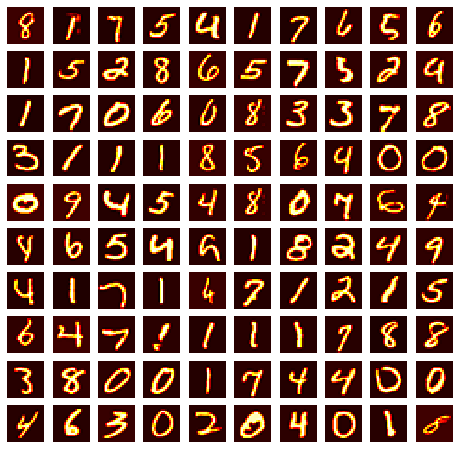

In [3]:
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot")
        axis[i,j].axis("off")

## Computing the Cost Function

$J(\theta)=\frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-(h_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$

$\frac{\Delta J(\theta)}{\Delta\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$ for $j=0$

$\frac{\Delta J(\theta)}{\Delta\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}+\frac{\lambda}{m}\theta_j$ for $j\ge1$

theta : (n, 1)
X : (m, n)
y : (m, 1)

predictions : (m, 1)
error : (m, 1)
cost, regCost : (1, 1)

In [4]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

In [5]:
def IrCostFunction(theta, X, y, Lambda):
    m=len(y)
    predictions=sigmoid(X @ theta)
    error=(-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    j_0=1/m * (X.transpose() @ (predictions - y))[0]
    j_1=1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad=np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

In [6]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t = np.array([np.linspace(0.1, 1.5, 15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = IrCostFunction(theta_t, X_t, y_t, 3)
print("Cost:",J,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


## One-vs-all Classification

In [7]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    m=len(y)
    J_history=[]
    
    for i in range(num_iters):
        cost, grad = IrCostFunction(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta, J_history

In [8]:
def oneVsAll(X,y,num_labels,Lambda):
    m,n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J = []
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        theta, J_history = gradientDescent(X, np.where(y==i,1,0), initial_theta, 1, 300, Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    
    return np.array(all_theta).reshape(num_labels,n+1), all_J

In [9]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)

## Plotting of Cost function

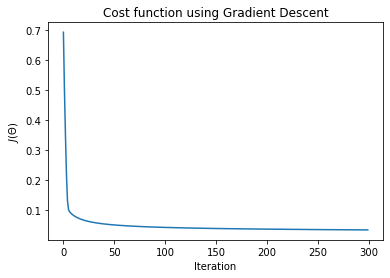

In [10]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

## One-vs-all Prediction

X : (m, n+1) m=5000 ->(데이터셋 개수), n=400 ->(각 데이터셋의 픽셀 수)  
theta : (10, n+1) 10 ->(class의 개수)
predictions : (m, 10)
    
numpy.argmax() : 최대값의 index를 출력 (axis = 인덱싱을 할 차원 지정)

리턴값에 1을 더하는 이유 : 데이터셋이 보이는 것처럼 0-9가 아닌 1-10으로 분류돼있음

In [11]:
def predictOneVsAll(all_theta, X):
    m= X.shape[0]
    X= np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    
    return np.argmax(predictions,axis=1)+1

In [12]:
pred = predictOneVsAll(all_theta, X)
print("Training Set Accuracy:", sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 91.46 %


# Neural Networks

## Loading of theta

In [13]:
mat2=loadmat("ex3weights.mat")
Theta1=mat2["Theta1"]
Theta2=mat2["Theta2"]

## Feedforward propagation

X : (m, n+1) m=5000, n=400  
a1 : (5000, 25)  
a2 : (5000, 26)  
Theta1 : (25, n+1)  
Theta2 : (10, 26)

In [14]:
def predict(Theta1, Theta2, X):
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1))
    a2 = sigmoid(a1 @ Theta2.T)
    
    return np.argmax(a2,axis=1)+1

In [15]:
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 97.52 %


## Compute the Neural Networks cost function

$J(\theta)=\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^k[-y_k^{(i)}log(h_\theta(x^{(i)})_k)-(1-y_k^{(i)}log(1-h_\theta(x^{(i)})_k)]+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{j=1}^{s_l+1}\sum_{k=1}^{s_l}(\theta_{j,k}^{(l)})^2$

$J(\theta)=\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^k[-y_k^{(i)}log(h_\theta(x^{(i)})_k)-(1-y_k^{(i)}log(1-h_\theta(x^{(i)})_k)]+\frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\theta_{j,k}^{(2)})^2]$

numpy.flatten() : array를 1차원 형태로 만듦

input_layer_size : 400  
hidden_layer_size : 25  
num_labels : 10  
X : (m, n+1)  
y : (m, 1)  
m : 5000  

먼저 forward propagation의 과정을 거쳐서 output layer의 $h_\theta(x)$와 error를 구해야 함

theta1과 theta2를 flattent하고 append한 1행 형태의 array를 nn_params로 넘겨줌  
이 nn_params중 앞의 (input_layer_size+1 * hidden_layer_size)개의 원소들은 Theta1이 되고, 나머지는 Theta2가 됨

Theta1 : (25, 401)  
Theta2 : (10, 26)  

a1 : (m, 25+1)  
a2 : (m, 10)  

y10 : (m, 10), 한 개의 행에는 y의 데이터와 같은 열번호에 1이 입력됨

cost, reg_J 계산이 끝나고 난 이후에는 back propagation의 과정을 거침

for문은 m=5000번 반복됨  
xi : (401)  
a1i : (26)  
a2i : (10)  
d2 : (10) -> output layer의 error  
d1 : (26) -> hidden layer의 error  
grad1, grad1_reg : (25, 401) -> hidden layer의 cost function의 theta1에 대한 편미분항  
grad2, grad1_reg : (10, 26) -> output layer의 cost function의 theta2에 대한 편미분항

In [16]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1))
    a2 = sigmoid(a1 @ Theta2.T)
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
                                            
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
                                            
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:]
        a1i = a1[i,:]
        a2i = a2[i,:]
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2= grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T

    grad1 = 1/m * grad1
    grad2 = 1/m * grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

In [17]:
def sigmoidGradient(z):
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid)

In [18]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost at parameters (non-regularized):",J,"\nCost at parameters (Regularized):",reg_J)

Cost at parameters (non-regularized): 0.28762916516131876 
Cost at parameters (Regularized): 0.3837698590909235


## Random initialization

$[-\epsilon_{init}, \epsilon_{init}]$범위 내에서 $\theta^{(l)}$을 초기화함

네트워크 내의 유닛 개수를 기반으로 $\epsilon_{init}$을 정함

$\epsilon_{init}=\frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$

In [19]:
def randInitializeWeights(L_in, L_out):
    epi = (6**1/2) / (L_in + L_out)**1/2
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [20]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [21]:
debug_J  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 3)
print("Cost at (fixed) debugging parameters (w/ lambda = 3):",debug_J[3])

Cost at (fixed) debugging parameters (w/ lambda = 3): 0.5760512469501329


## Learning parameters using Gradient Descent

기울기 하강은 아래 코드에서 800회 실행되고, 각 실행마다 cost function의 계산에서 back propagation이 각 테스트 데이터의 갯수인 5000번씩 반복되므로 800 x 5000회의 매트릭스 연산 실행. 실행속도 느림

In [22]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1) * hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in tqdm(range(num_iters)):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [ ]:
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,0.8,800,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

c:\users\lee\anaconda3\envs\mlai\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [24]:
pred3 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 94.12 %
